### (1) Install and Import Dependencies

In [181]:
# pip install easyocr

In [182]:
# pip install imutils

In [1]:
import cv2
import matplotlib.pyplot as plt
import easyocr
import imutils
import numpy as np

### (2) Read Image, Grayscale and Blur

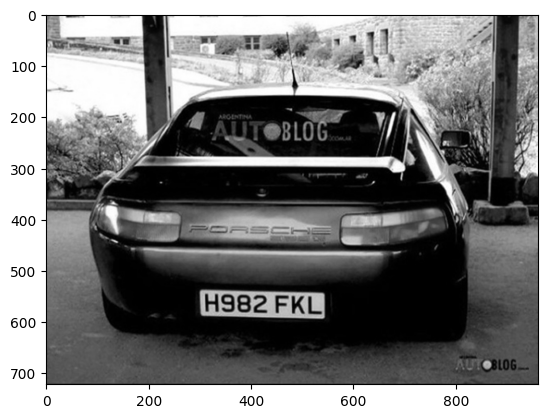

In [2]:
img = cv2.imread('image4.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray,cv2.COLOR_BGR2RGB))

### (3) Apply filter and find edges for localization

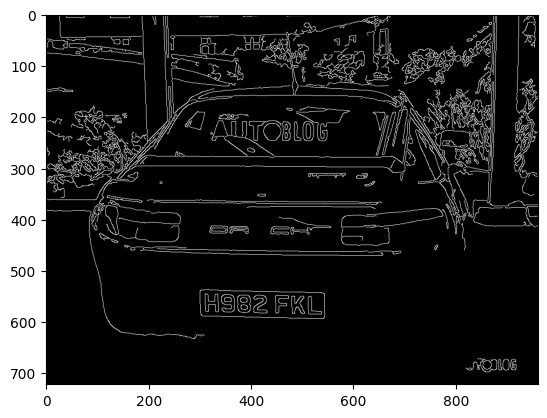

In [3]:
bfilter = cv2.bilateralFilter(gray,11,17,17) # noise reduction  (img, d , sigmaColor , sigmaSpace)

# [ note : smaller value of sigmaColor make the filter more sensitive to colors! ]

edged = cv2.Canny(bfilter,20,300) # edge detection  ( filteredimg(np array), threshsold1 , thresold2 )  

# [ note : pixelvalue < thresh1 => directly excluded pixelvalue>thresh2 => directly included and for thresh1 < pixelvalue < thresh2 => included only if it is partially related to thresh2

plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

### (4) Find Contours and Apply Mask

In [4]:
keypoints = cv2.findContours(edged.copy() , cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE ) # cv2.RETR_TREE => for extracting both, internal and exteranl contours in a tree grap 
contours = imutils.grab_contours(keypoints)     
contours = sorted(contours, key = cv2.contourArea , reverse = True)[:10]

In [5]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour,10,True) # allows us to approxify the contours from polygon!
    # cv2.approx( contour, approx accuracy, closed : bool)
    if len(approx) == 4 :
        location = approx
        break

In [6]:
location

array([[[300, 540]],

       [[306, 589]],

       [[543, 592]],

       [[538, 543]]], dtype=int32)

### (5) Use Easy OCR To Read Text

In [7]:
mask = np.zeros( gray.shape , np.uint8) # np.uint8 => 8 -bit unsigned integer commonly used for pixel values in gray scale image!

# draw contour on the mask
new_image = cv2.drawContours(mask, [location] , 0, 255,-1) # ( mask , [ location ] , locindex , grayscale color , fill ) fill = -1 => fill contour with grayscale color! or simply just draw the border!

new_image = cv2.bitwise_and(img,img ,mask = mask) 

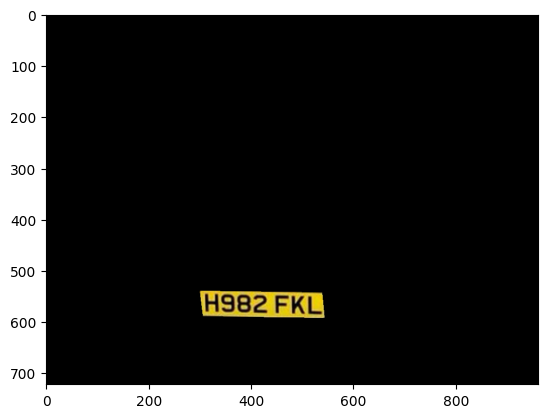

In [8]:
plt.imshow(cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB))

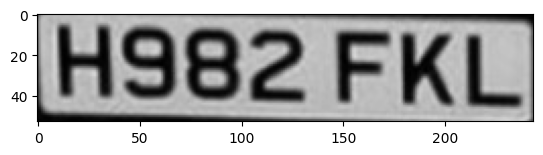

In [9]:
(x, y) = np.where( mask == 255)
(x1,y1) = ( np.min(x) , np.min(y) ) 
(x2, y2) = ( np.max(x) , np.max(y) )

cropped_image = gray [ x1:x2+1 , y1:y2+1 ]

plt.imshow(cv2.cvtColor( cropped_image , cv2.COLOR_BGR2RGB) ) 

### (6) Render Result

In [10]:
reader = easyocr.Reader(['en'])
result = reader.readtext( cropped_image ) 
print(result)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 0], [244, 0], [244, 53], [0, 53]], 'H982 FKL', 0.9769778851628141)]


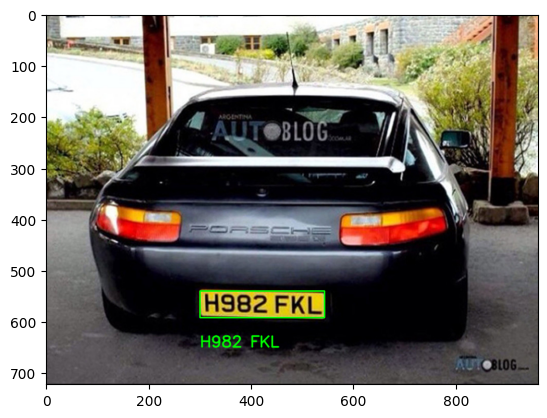

In [11]:
font = cv2.FONT_HERSHEY_SIMPLEX

textvar = ' '

if len(result) == 1:
    textvar = result[0][-2]
# to handle IND numberplates!
elif len(result)>1:
    for i in range(len(result)):
        textvar += result[i][-2]
else:
    textvar = 'sorry machine do not find text!'


res = cv2.putText( img, text = textvar, fontScale = 1, fontFace = font , 
                  lineType = cv2.LINE_AA , thickness=2, color = (0,255,0),
                  org = ( approx[0][0][0] , approx[1][0][1]+60) )


res = cv2.rectangle ( img, tuple(approx[0][0]) , tuple(approx[2][0]) , (0,255,0), 2)

plt.imshow( cv2.cvtColor( res, cv2.COLOR_BGR2RGB) )

In [12]:
from csv import writer

with open('ANPR.CSV','a') as file:
    fo = writer(file)
    fo.writerow([textvar])

In [13]:
import pandas as pd

df = pd.read_csv('ANPR.csv')

df

,Numberplates
0,HR.26 BR.9044
1,ICOVIDT9
2,EBJY. 982|
3,H982 FKL
4,MH 02 VD 2636
5,H982 FKL
